In [ ]:
import sys, os, glob
import numpy as np
import scipy as sp
from typing import List, Tuple, Callable, Any, Dict
import matplotlib.pyplot as plt
from methods.PolyCG.polycg.SO3 import so3
from methods.PolyCG.polycg.transforms.transform_marginals import send_to_back_permutation
from methods.read_nuc_data import read_nucleosome_triads, GenStiffness

from methods.midstep_composites import midstep_composition_transformation, midstep_se3_groundstate
from methods.midstep_composites import midstep_composition_transformation_correction, midstep_composition_transformation_correction_old
from methods.read_nuc_data import read_nucleosome_triads, GenStiffness
from methods.midstep_composites import midstep_groundstate
from methods.free_energy import calculate_midstep_triads, midstep_excess_vals

np.set_printoptions(linewidth=10000,precision=5,suppress=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate Stiffness

In [ ]:
seq = "CTGGAGAATCCCGGTGCCGAGGCCGCTCAATTGGTCGTAGACAGCTCTAGCACCGCTTAAACGCACGTACGCGCTGTCCCCCGCGTTTTAACCGCCAAGGGGATTACTCCCTAGTCTCCAGGCACGTGTCAGATATATACATCCTGT"
method = 'hybrid'


genstiff = GenStiffness(method=method)   # alternatively you can use the 'crystal' method for the Olson data
stiffmat,gs = genstiff.gen_params(seq,use_group=True)
triadfn = 'methods/State/Nucleosome.state'
nuctriads = read_nucleosome_triads(triadfn)

mid_locs = [
    2, 6, 14, 17, 24, 29, 
    34, 38, 45, 49, 55, 59, 
    65, 69, 76, 80, 86, 90, 
    96, 100, 107, 111, 116, 121, 
    128, 131, 139, 143
]

midtriads = calculate_midstep_triads(
    mid_locs,
    nuctriads
)

In [ ]:
mid_locs = np.arange(2,144,10)

### Load Annealing data

In [1394]:
fn = 'test_data/minstate_601ct.npy'
mcvals = np.load(fn)

# mcvals[:,0] = 0
# mcvals[:,1] = 0.05
# mcvals[:,2] = 0

nuctriads = np.zeros((len(mcvals)+1,4,4))
nuctriads[0] = np.eye(4)
for i in range(len(mcvals)):
    s = so3.se3_euler2rotmat(gs[i])
    d = so3.se3_euler2rotmat(mcvals[i])
    nuctriads[i+1] = nuctriads[i] @ s @ d

midtriads = calculate_midstep_triads(
    mid_locs,
    nuctriads
)

### Testing excess value

In [1395]:
Yk0 = midstep_groundstate(gs,mid_locs)

# find contraint excess values
excess_vals = midstep_excess_vals(
    gs,
    mid_locs,
    midtriads
)
C = excess_vals.flatten()

gk = []
sk = []
dk = []
Ykd = []
for i in range(len(mid_locs)-1):
    g = np.linalg.inv(midtriads[i]) @ midtriads[i+1]
    s = so3.se3_euler2rotmat(Yk0[i])
    d = np.linalg.inv(s) @ g
    Y = so3.se3_rotmat2euler(d)
    gk.append(g)
    sk.append(s)
    dk.append(d)
    Ykd.append(Y)
 
gk = np.array(gk)
sk = np.array(sk)
dk = np.array(dk)
Ykd_exact = np.array(Ykd)

print(C[:6])
print(Ykd_exact.flatten()[:6])

[-0.22215  0.09475 -0.04183  0.0648   0.19606 -0.03598]
[-0.22215  0.09475 -0.04183  0.0648   0.19606 -0.03598]


----
# Compare exact value to linear transformation
----

### calculate linear transformation

In [1396]:
# from time import time
# t1 = time()
# for i in range(100):
# t2 = time()
# print(f'dt = {t2-t1}')
    
    
# find composite transformation
transform, replaced_ids = midstep_composition_transformation(
    gs,
    mid_locs
)

# transform stiffness matrix
inv_transform = np.linalg.inv(transform)

# rearrange stiffness matrix
full_replaced_ids = list()
for i in range(len(replaced_ids)):
    full_replaced_ids += [6*replaced_ids[i]+j for j in range(6)]
    
P = send_to_back_permutation(len(stiffmat),full_replaced_ids)

A = P @ transform

### Old Correction

In [1397]:
np.set_printoptions(linewidth=10000,threshold=np.inf,edgeitems=6,precision=5,suppress=True)

use_old = 0

# find composite transformation

corr_transform_old, replaced_ids = midstep_composition_transformation_correction_old(
    gs,
    mid_locs,
    -mcvals
)

# transform stiffness matrix
inv_corr_transform_old = np.linalg.inv(corr_transform_old)
    
Ap_old = P @ corr_transform_old

### New Correction

In [1407]:
np.set_printoptions(linewidth=10000,threshold=np.inf,edgeitems=6,precision=5,suppress=True)

use_old = 0

# find composite transformation

shifts = []   
 
corr_transform, replaced_ids, shifts = midstep_composition_transformation_correction(
    gs,
    mid_locs,
    mcvals
)

if use_old:
    corr_transform, replaced_ids = midstep_composition_transformation_correction_old(
        gs,
        mid_locs,
        -mcvals
    )

# transform stiffness matrix
inv_corr_transform = np.linalg.inv(transform)
    
Ap = P @ corr_transform

shift = shifts.reshape((len(shifts)//6,6))

# shift = np.zeros((len(shifts),6))
# shift[:,3:] = np.array(shifts)

# print(shift.shape)



### Compare dynamic components

In [1408]:
# basic
Yp = A @ mcvals.flatten()
Yp = Yp.reshape((len(Yp)//6,6))

print(len(Yp))
Ykd = Yp[-len(Ykd_exact):]

# new correction
Ypp = Ap @ mcvals.flatten()
Ypp = Ypp.reshape((len(Ypp)//6,6))

print(len(Yp))
Ykdp = Ypp[-len(Ykd_exact):]


# neoldw correction
Ypp_old = Ap_old @ mcvals.flatten()
Ypp_old = Ypp_old.reshape((len(Ypp_old)//6,6))

print(len(Yp))
Ykdp_old = Ypp_old[-len(Ykd_exact):]


for i in range(len(Ykd)):
    print(f'step {i}')
    print(Ykd_exact[i])
    print(Ykd[i])
    print(Ykdp[i])
    

146
146
146
step 0
[-0.22215  0.09475 -0.04183  0.0648   0.19606 -0.03598]
[-0.22319  0.09296 -0.03891  0.05115  0.19952 -0.01841]
[-0.22319  0.09296 -0.03891  0.05371  0.19601 -0.03144]
step 1
[ 0.13294 -0.27924  0.07726 -0.22023 -0.14977 -0.05845]
[ 0.13317 -0.2781   0.07958 -0.22832 -0.14967 -0.03154]
[ 0.13317 -0.2781   0.07958 -0.21883 -0.14876 -0.05017]
step 2
[-0.22127  0.32879 -0.10723  0.34195  0.13277 -0.05103]
[-0.21818  0.32762 -0.11673  0.33319  0.14649  0.00259]
[-0.21818  0.32762 -0.11673  0.33269  0.13602 -0.03423]
step 3
[ 0.16849 -0.42235  0.0302  -0.34749 -0.23997 -0.07424]
[ 0.17481 -0.41891  0.03293 -0.35919 -0.24311 -0.0116 ]
[ 0.17481 -0.41891  0.03293 -0.35697 -0.24116 -0.06016]
step 4
[ 0.1988   0.47176  0.00785  0.45466 -0.14718  0.02219]
[ 0.21087  0.4657   0.0211   0.4265  -0.16014  0.10461]
[ 0.21087  0.4657   0.0211   0.44344 -0.15349  0.04427]
step 5
[-0.41901 -0.3209  -0.0257  -0.26259  0.58554 -0.17918]
[-0.41312 -0.33077 -0.02946 -0.31871  0.60112 -0.0

0.10004259728859391
0.10004259728859402
0.09595197695315584
0.09595197695315565
0.1464222788164038
0.1464222788164038
0.20776583153098432
0.3802173938193331
0.0765759656210069
0.2958230997207506
0.4061458337015317
0.2767911952554005


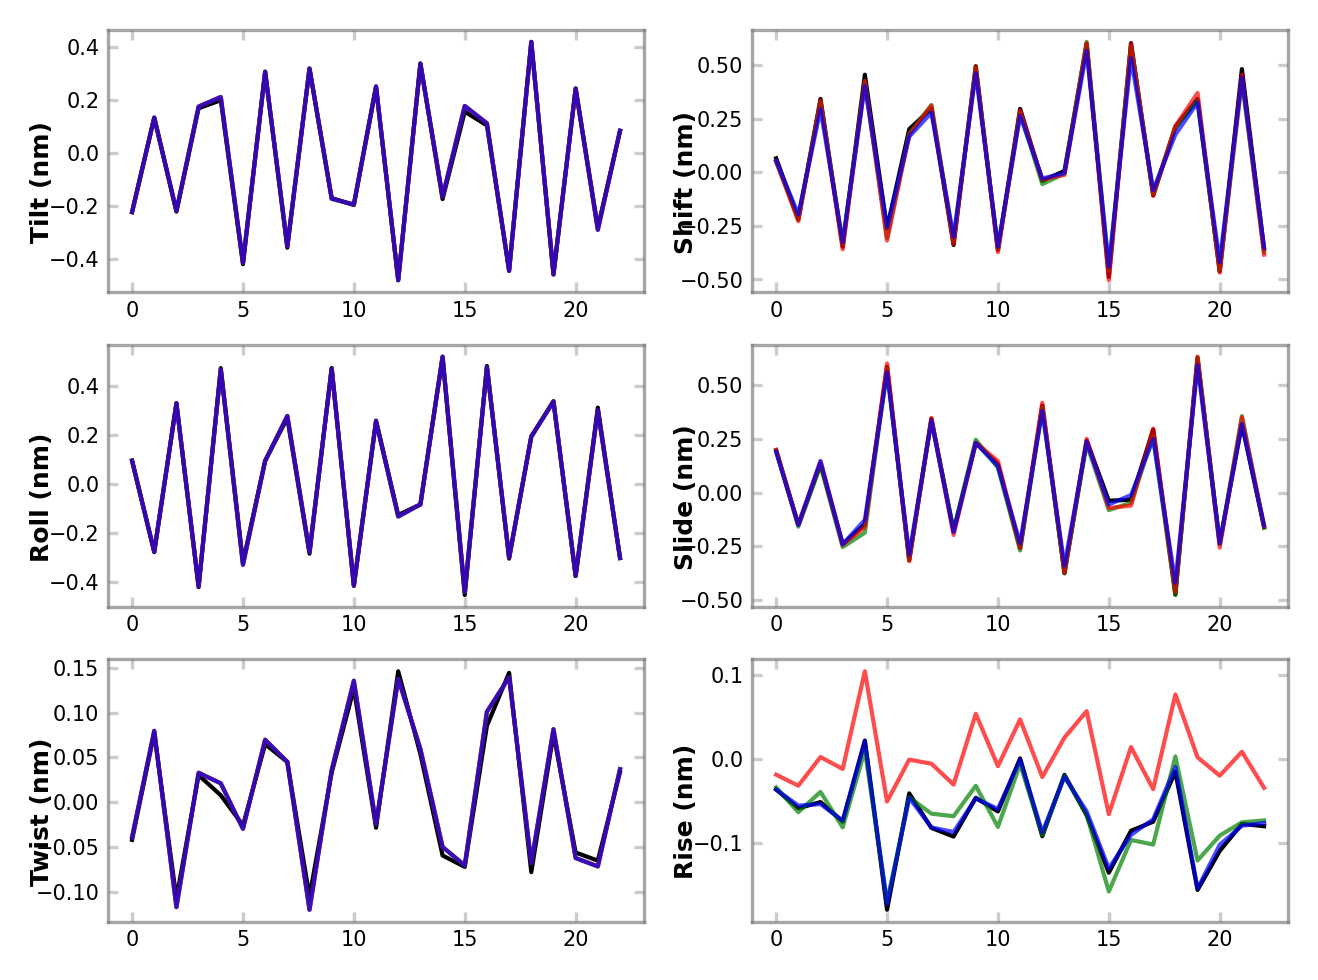

In [1409]:
def cm_to_inch(cm: float) -> float:
    return cm/2.54

fig_width = 8.6*1.5
fig_height = 10

axlinewidth  = 0.8
axtick_major_width  = 0.8
axtick_major_length = 2.4
axtick_minor_width  = 0.4
axtick_minor_length = 1.6

tick_pad        = 2
tick_labelsize  = 5
label_fontsize  = 6
legend_fontsize = 6

panel_label_fontsize = 8
label_fontweight= 'bold'
panel_label_fontweight= 'bold'


fig = plt.figure(figsize=(cm_to_inch(fig_width), cm_to_inch(fig_height)), dpi=300,facecolor='w',edgecolor='k') 
axes = []
axes.append(fig.add_subplot(321))
axes.append(fig.add_subplot(323))
axes.append(fig.add_subplot(325))
axes.append(fig.add_subplot(322))
axes.append(fig.add_subplot(324))
axes.append(fig.add_subplot(326))

labels = ['Tilt','Roll','Twist','Shift','Slide','Rise']

for d in range(6):
    axes[d].plot(np.arange(len(Ykd)),Ykd_exact[:,d],lw=1,color='black')
    axes[d].plot(np.arange(len(Ykd)),Ykdp_old[:,d],lw=1,color='green',alpha=0.7)
    axes[d].plot(np.arange(len(Ykd)),Ykd[:,d],lw=1,color='red',alpha=0.7)
    axes[d].plot(np.arange(len(Ykd)),Ykdp[:,d]+shift[:,d],lw=1,color='blue',alpha=0.7)
    
    # axes[d].plot(np.arange(len(Ykd)),np.abs(Ykdp[:,d]-Ykd_exact[:,d]),lw=1,color='black')
    # axes[d].plot(np.arange(len(Ykd)),np.abs(Ykdp_old[:,d]-Ykd_exact[:,d]),lw=1,color='green')
    
    print(np.sum(np.abs(Ykdp[:,d]-Ykd_exact[:,d])))
    print(np.sum(np.abs(Ykdp_old[:,d]-Ykd_exact[:,d])))
    
    ax = axes[d]
    label = labels[d]
    if i < 3:
        label = f'{label} (rad)'
    else:
        label = f'{label} (nm)'
        
    ax.set_ylabel(label,fontsize=label_fontsize,fontweight=label_fontweight,rotation=90)
    ax.yaxis.set_label_coords(-0.1,0.42)
    # ax.set_xlim((-1,146))
    
    
##############################################
# Axes configs
for ax in axes:
    ###############################
    # set major and minor ticks
    ax.tick_params(axis="both",which='major',direction="in",width=axtick_major_width,length=axtick_major_length,labelsize=tick_labelsize,pad=tick_pad,color='#cccccc')
    ax.tick_params(axis='both',which='minor',direction="in",width=axtick_minor_width,length=axtick_minor_length,color='#cccccc')

    ###############################
    ax.xaxis.set_ticks_position('both')
    # set ticks right and top
    ax.yaxis.set_ticks_position('both')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(axlinewidth)
        ax.spines[axis].set_color('grey')
        ax.spines[axis].set_alpha(0.7)
        
savefn = 'test_data/mid_comparison'
fig.savefig(savefn+'.pdf',dpi=300,transparent=True)
fig.savefig(savefn+'.svg',dpi=300,transparent=True)
fig.savefig(savefn+'.png',dpi=300,transparent=False)

# Sandbox

In [1410]:
print(gs.shape)
print(mcvals.shape)
id1 = 10
id2 = 12
gs_sel = gs[id1:id2]
mc_sel = mcvals[id1:id2]

s = np.zeros((len(gs_sel),4,4))
d = np.zeros((len(gs_sel),4,4))
g = np.zeros((len(gs_sel),4,4))
gtot = np.eye(4)
for i in range(len(s)):
    s[i] = so3.se3_euler2rotmat(gs_sel[i])
    d[i] = so3.se3_euler2rotmat(mc_sel[i])
    g[i] = s[i] @ d[i]
    gtot @= g[i]  
Yk = so3.se3_rotmat2euler(gtot)

 
print(gtot)
print(Yk)


(146, 6)
(146, 6)
[[ 0.31881 -0.91742  0.23812  0.03732]
 [ 0.92846  0.3528   0.11617  0.04532]
 [-0.19058  0.18405  0.96426  0.66903]
 [ 0.       0.       0.       1.     ]]
[0.04465 0.28198 1.21413 0.03732 0.04532 0.66903]
